In [1]:
# commmon libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#warnings
import warnings
warnings.filterwarnings("ignore")

# sklearn and ml libs
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.preprocessing import StandardScaler
#linear Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
# score metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# Custom visualization entegrations
colors = ['#66c2a5','#fc8d62','#8da0cb']
sns.set_palette(sns.color_palette(colors))

## EDA and Visualizations
    * Data types
    * Target ratio (No need for regression - this data has continous target distribution)
    * Feature examination
    * Missing Values
    * Data distribution

### Original feature info from dataset's main page

   > 
   - GRE Scores ( out of 340 ) 
       * ___The Graduate Record Examinations (GRE) is a standardized test that is an admissions requirement for many graduate schools in the United States and Canada and few in other countries.[site](https://en.wikipedia.org/wiki/Graduate_Record_Examinations)___
   - TOEFL Scores ( out of 120 )
       * ___Toefle is the one of the most popular Egnlish tests around the world. 4 parts of test (writing, speaking, listening and reading)___
   - University Rating ( out of 5 )
   - Statement of Purpose and Letter of Recommendation Strength ( out of 5 )
   - Undergraduate GPA ( out of 10 )
   - Research Experience ( either 0 or 1 )
   - LOR (Letter of Recommendations) (Added)
   - **__Chance of Admit ( ranging from 0 to 1 )__**


**NOTES:** 

    * Data has no missing values
    * Serial no is the fully unique one, chosen as an index
    * Some column names has extra spaces - renaming
    

---

### Data loading, column renaming and basic analysis

In [3]:
data = pd.read_csv("dataset/Admission_Predict_Regression.csv", index_col="Serial No.")
data.rename(columns={"LOR ":"LOR", 'Chance of Admit ': 'Chance', "GRE Score":"GRE", "TOEFL Score":"TOEFL", "University Rating":"UniversityRating"}, inplace=True)
data.head()

,GRE,TOEFL,UniversityRating,SOP,LOR,CGPA,Research,Chance
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
print("Data Shape : ", data.shape)

Data Shape :  (500, 8)


In [5]:
print("Data Types : \n",data.dtypes) # all numerics


Data Types : 
 GRE                   int64
TOEFL                 int64
UniversityRating      int64
SOP                 float64
LOR                 float64
CGPA                float64
Research              int64
Chance              float64
dtype: object


In [6]:
print("Missing Values :\n", data.isnull().sum()) # no missing values

Missing Values :
 GRE                 0
TOEFL               0
UniversityRating    0
SOP                 0
LOR                 0
CGPA                0
Research            0
Chance              0
dtype: int64


In [7]:
print("column Names : ", data.columns)

column Names :  Index(['GRE', 'TOEFL', 'UniversityRating', 'SOP', 'LOR', 'CGPA', 'Research',
       'Chance'],
      dtype='object')


In [8]:
data[data.duplicated()] # No dublicated

,GRE,TOEFL,UniversityRating,SOP,LOR,CGPA,Research,Chance
Serial No.,,,,,,,,


In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
GRE,500.0,316.47200,11.295148,290.00,308.0000,317.00,325.00,340.00
TOEFL,500.0,107.19200,6.081868,92.00,103.0000,107.00,112.00,120.00
UniversityRating,500.0,3.11400,1.143512,1.00,2.0000,3.00,4.00,5.00
SOP,500.0,3.37400,0.991004,1.00,2.5000,3.50,4.00,5.00
LOR,500.0,3.48400,0.925450,1.00,3.0000,3.50,4.00,5.00
CGPA,500.0,8.57644,0.604813,6.80,8.1275,8.56,9.04,9.92
Research,500.0,0.56000,0.496884,0.00,0.0000,1.00,1.00,1.00
Chance,500.0,0.72174,0.141140,0.34,0.6300,0.72,0.82,0.97


In [10]:
data.iloc[:].nunique() # unique thres is 10 here

GRE                  49
TOEFL                29
UniversityRating      5
SOP                   9
LOR                   9
CGPA                184
Research              2
Chance               61
dtype: int64

Most of the data is suitable for regression, pairplot is a perfect plotting technique for analyzing distributions between pair features

<Figure size 1440x1152 with 0 Axes>

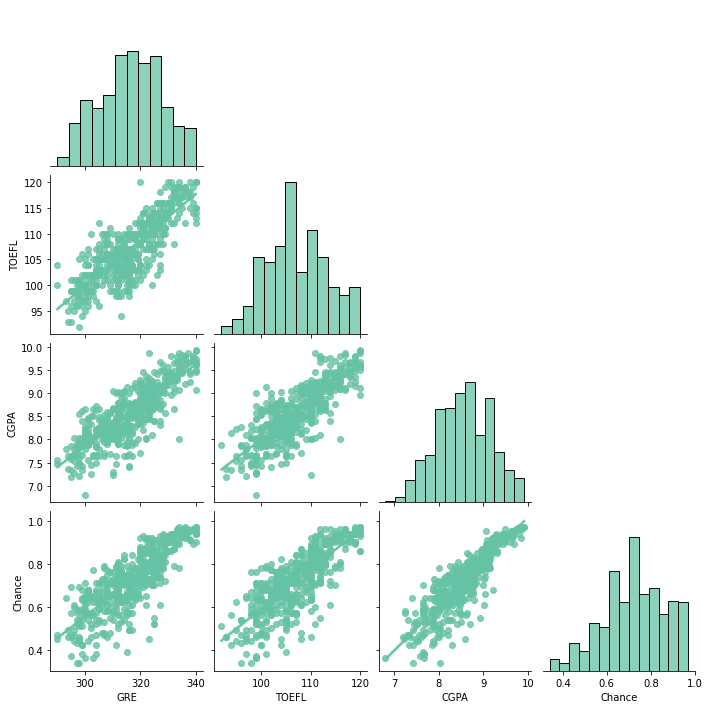

CPU times: user 3.15 s, sys: 55.3 ms, total: 3.2 s
Wall time: 3.03 s


In [11]:
%%time
plt.figure(figsize=(20, 16))
sns.pairplot(data, kind="reg", vars =  list(data.loc[:,data.apply(pd.Series.nunique) > 10].columns), corner=True)
plt.show()

### Chosing remaining features to see their relations between target value and more

In [12]:
for col in list(data.loc[:,data.apply(pd.Series.nunique) < 10].columns):
    print(f"{col} : {data[col].unique()}")

UniversityRating : [4 3 2 5 1]
SOP : [4.5 4.  3.  3.5 2.  5.  1.5 1.  2.5]
LOR : [4.5 3.5 2.5 3.  4.  1.5 2.  5.  1. ]
Research : [1 0]


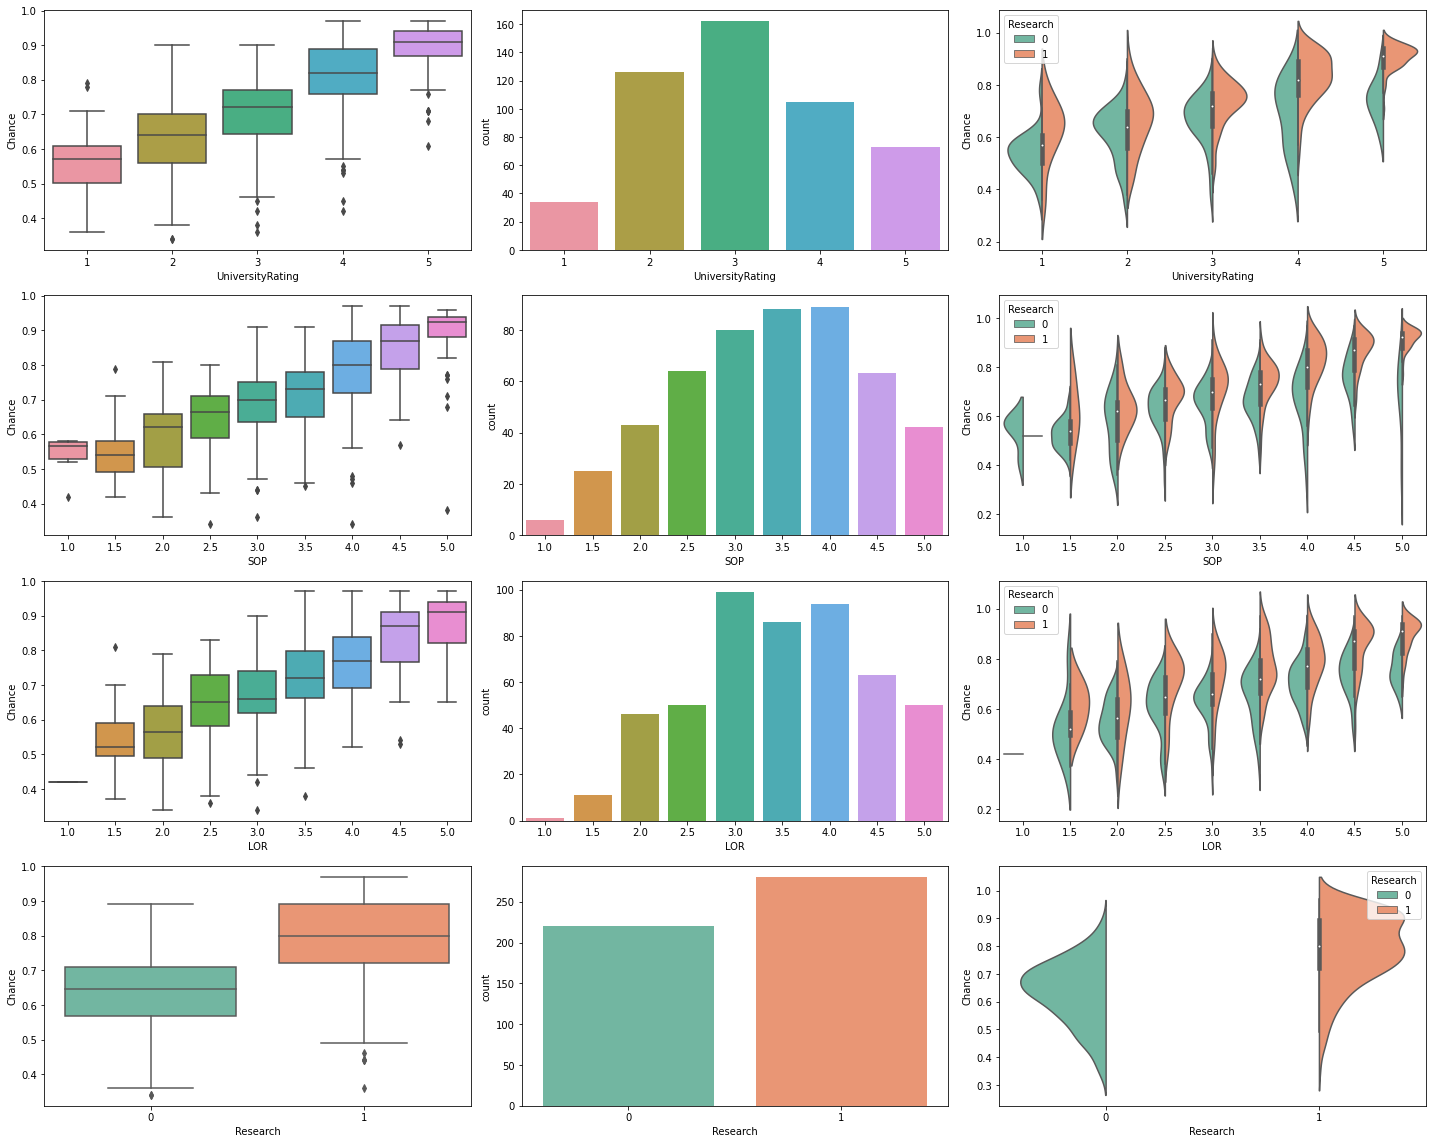

In [13]:
fig, axes = plt.subplots(4,3, figsize=(20,16))
for index, col in enumerate(list(data.loc[:,data.apply(pd.Series.nunique) < 10].columns)):
    sns.boxplot(x=col ,y="Chance" ,data=data, ax=axes[index][0])
    sns.countplot(x=col, data=data, ax=axes[index][1])
    sns.violinplot(x=col, y="Chance", hue="Research", split=True, data=data, ax=axes[index][2])
plt.tight_layout()
plt.show()

---

## Data Transformations
    * Split - Train - Test - Validation (not recommended in small datasets, but we'll try anyway)
    * Encoding - if needed
    * Scaling - if needed

In [14]:
# features - target 
X, y = data.drop("Chance", axis=1), data["Chance"]
# first splitting - it is most frequent usage - we get train and test sets, Note: better to use stratify parameter for classifications
X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=.2, shuffle=True, random_state=22)
# second splitting is needed for validation data set
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=.5, shuffle=True, random_state=22)

## Machine Learning
    * Model Trainings
    * Scoring

In [15]:
# there is more models in sklearn llibrary, easy to implement with this code 
# just need to add model in this models list
# one time coding, using with any type of (linear) models
models = [LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), KNeighborsRegressor()]
scores = []
predictions = {}
coefs = {}

for model in models:
    model.fit(X_train,y_train)
    scores.append(model.score(X_valid,y_valid))
    predictions[model] = model.predict(X_valid)
    try:
        #print(f"{model},  {model.coef_}")     # linear - lasso - ridge // lasso is not a good option for small datasets ** check ->  l1 & l2 REGULARIZATION affects
        coefs[model] = model.coef_
    except:
        pass
output = pd.DataFrame(data={"Model": models,
                           "score" : scores} )
output

,Model,score
0,LinearRegression(),0.816090
1,Lasso(),0.222184
2,Ridge(),0.815707
3,DecisionTreeRegressor(),0.751455
4,KNeighborsRegressor(),0.722169


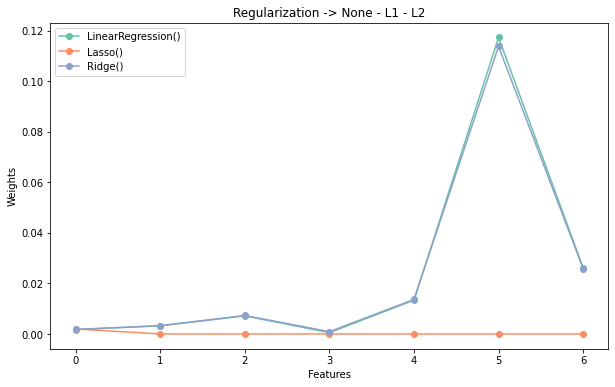

In [16]:
# usage of lasso can be dangerous
# it might be better to use Lasso for data with more features/columns ** weight regularization 
plt.figure(figsize=(10,6))
for coef in coefs.keys():
    plt.plot(coefs[coef], label=coef, marker="o")
plt.xlabel("Features")
plt.ylabel("Weights")
plt.title("Regularization -> None - L1 - L2")
plt.legend()
plt.show()

---

### Metrics Section
    - check metrics list on sklearn metrics site
    - most popular, well known metrics are accuracy and RSquare, accuracy for[balanced target] Classification and we aim high acc
    - but in regression models we use errors most, these are errors so that we aim less values within these metrics/scores

### Most used metrics for regression models 
    - R2 
    - Mean Absolute Error
    - Mean Squared Error
    - Root Mean Squared Error
 Detailed Explanation and break down here -> [scikit-learn regression metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

In [17]:
# predictions to use with metrics
#r2_scores = []
mse = []
rmse = []
mae = []

# score
for model in models:
    mse.append(mean_squared_error(y_test, predictions[model]))
    rmse.append(np.sqrt(mean_absolute_error(y_test, predictions[model])))
    mae.append(mean_absolute_error(y_test, predictions[model]))
    #r2_scores.append(r2_score(y_test, predictions[model]))

#output["r2"] = pd.Series(r2_scores)
output["mse"] = pd.Series(mse)
output["rmse"] = pd.Series(rmse)
output["mae"] = pd.Series(mae)

output  

,Model,score,mse,rmse,mae
0,LinearRegression(),0.816090,0.039673,0.398306,0.158648
1,Lasso(),0.222184,0.019261,0.330292,0.109093
2,Ridge(),0.815707,0.039535,0.398134,0.158511
3,DecisionTreeRegressor(),0.751455,0.039924,0.400500,0.160400
4,KNeighborsRegressor(),0.722169,0.037996,0.405906,0.164760


---

## HyperParameter Tuning
    * Model specific 
    * Girdsearch and CV

In [18]:
# Trying Cross Valitdation 
for model in models:
    cv = cross_val_score(model, X_train, y_train, cv=5)
    print(model , cv.mean())

LinearRegression() 0.7998402641116411
Lasso() 0.22287124719428492
Ridge() 0.8000084899443529
DecisionTreeRegressor() 0.5801332181149796
KNeighborsRegressor() 0.7024237283570973


In [19]:
# check out parameters for fine tuning
print(LinearRegression().get_params().keys())
print(Ridge().get_params().keys())
print(Lasso().get_params().keys())
print(DecisionTreeRegressor().get_params().keys()) # better option for GridSearch
print(KNeighborsRegressor().get_params().keys())

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])
dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])
dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])
dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])
dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])


In [20]:
%%time
# Grid search -> tries all given hyperparameter
# Randomized Search -> chooses randomly from the given ones or given intervals

# Note : These params are only available with DecisionTreeRegressor - Check cell above for others
regression_params = {
                  "min_samples_leaf": [10, 20, 40,100],
                  "min_samples_split": [5, 10, 20],
                  "max_depth": [2, 6, 8, 12],
                  "max_leaf_nodes": [5, 15, 40, 100],
                  "criterion": ["mse", "mae", "r2"]
              }

rigde = DecisionTreeRegressor()
grid_linear = GridSearchCV(rigde, param_grid=regression_params, cv=5) # we have to choose one of them 
grid_linear.fit(X_train, y_train)
print(f"Best Score: {grid_linear.best_score_}")
print(f"Best Hyperparameters: {grid_linear.best_params_}")
    

Best Score: 0.7339093331255546
Best Hyperparameters: {'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 15, 'min_samples_leaf': 20, 'min_samples_split': 5}
CPU times: user 13.3 s, sys: 85.7 ms, total: 13.4 s
Wall time: 13.5 s


In [21]:
best_model = grid_linear.best_estimator_
y_pred = best_model.predict(X_valid)

r2_score = best_model.score(X_valid,y_valid)
print("R-squared:{:.5f}".format(r2_score))
print("MSE: %.5f" % mean_squared_error(y_valid, y_pred))

R-squared:0.78667
MSE: 0.00550


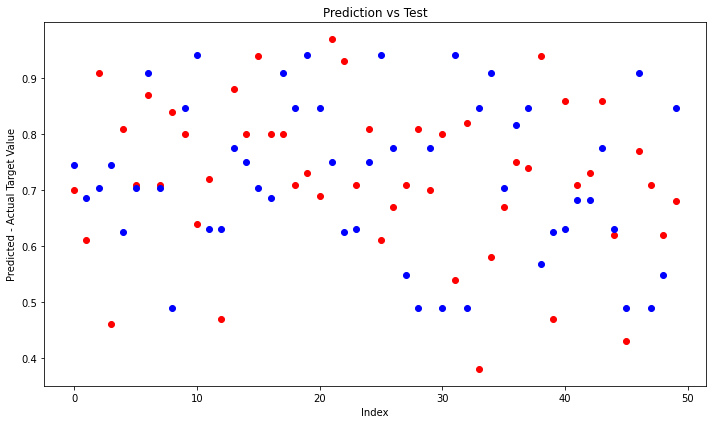

In [22]:
plt.figure(figsize=(10,6))
plt.plot(y_test.ravel(), color="red",marker="o", linestyle="None")
plt.plot(pd.DataFrame(y_pred), color="blue",marker="o", linestyle="None")
plt.title("Prediction vs Test")
plt.ylabel("Predicted - Actual Target Value")
plt.xlabel("Index")
plt.tight_layout()
plt.show()

In [23]:
pd.DataFrame(data={
    "Test" : y_test,
    "Prediction" : y_pred
}).style.background_gradient(cmap="Blues")

,Test,Prediction
Serial No.,,
263,0.700000,0.744500
124,0.610000,0.685424
446,0.910000,0.704000
29,0.460000,0.744500
326,0.810000,0.624500
120,0.710000,0.704000
471,0.870000,0.909706
467,0.710000,0.704000
312,0.840000,0.490000


---

## Final Assessment & Comments


    * Multiple plotting styles and different graphs -> data distribution is pretty much good
    * There is a few outliers - can be examined with different outlier detection and filling options - check -> IQR quartile range(Optional TO DO)
    * Train - Test - Validation sets used
    * Model Training and Tuning
    * Cross Valitdation - GridSearchCV
    * Usage of after fitting parameter such as coef_, best_estimator_ ...
    * Scores around - 0.75 R-squared - : - 0.005 MSE -
    * This notebook mostly focused on **EDA** and **Linear Model Understanding**.
    * Possible Next Update : > Adding other linear algorithms and parameter tuning > Optimizations > Training Curve Visualizations
    
    
    
    


**___Please feel free to pr if you have any thoughts, improvements or suggestions for this notebook, Thanks,___**

**__Enes__** 